# Imports

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

import os
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Count the images in each dataset

I used the Fair Face Dataset for unfiltered images, and the Fair Beauty Dataset for filtered images.

In [4]:
non_filtered_folder = "/home/ubuntu/dataset/unfiltered"
base_filtered_folder = "/home/ubuntu/dataset/filtered"


def count_images(folder):
    files = os.listdir(folder)
    images = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    return len(images)
    
non_filtered_folder = "dataset/unfiltered"
base_filtered_folder_val = "dataset/filtered/val"
base_filtered_folder_train = "dataset/filtered/train"

for filter_name in os.listdir(non_filtered_folder):
    filter_folder = os.path.join(non_filtered_folder, filter_name)
    if os.path.isdir(filter_folder):
        num_filtered_images = count_images(filter_folder)
        print(f'Number of {filter_name} unfiltered images: {num_filtered_images}')
        

for filter_name in os.listdir(base_filtered_folder_val):
    filter_folder = os.path.join(base_filtered_folder_val, filter_name)
    if os.path.isdir(filter_folder):
        num_filtered_images = count_images(filter_folder)
        print(f'Number of {filter_name} filtered val images: {num_filtered_images}')

for filter_name in os.listdir(base_filtered_folder_train):
    filter_folder = os.path.join(base_filtered_folder_train, filter_name)
    if os.path.isdir(filter_folder):
        num_filtered_images = count_images(filter_folder)
        print(f'Number of {filter_name} filtered train images: {num_filtered_images}')

Number of train unfiltered images: 86744
Number of val unfiltered images: 10954
Number of 005000 filtered val images: 915
Number of 006000 filtered val images: 906
Number of 000000 filtered val images: 881
Number of 007000 filtered val images: 904
Number of 001000 filtered val images: 893
Number of 002000 filtered val images: 901
Number of 003000 filtered val images: 903
Number of 008000 filtered val images: 864
Number of 004000 filtered val images: 907
Number of 010000 filtered val images: 851
Number of 009000 filtered val images: 881
Number of 066000 filtered train images: 921
Number of 015000 filtered train images: 913
Number of 022000 filtered train images: 917
Number of 041000 filtered train images: 906
Number of 058000 filtered train images: 919
Number of 051000 filtered train images: 927
Number of 079000 filtered train images: 917
Number of 080000 filtered train images: 918
Number of 005000 filtered train images: 900
Number of 042000 filtered train images: 902
Number of 071000 f

# Define Dataset Class

As can be seen, the Fair Face Dataset came with a train folder and a val folder that both contained images of unfiltered images, so labeling those were very simple.


For the Fair Beauty Dataset, each train and val folder came with separate batches of around 900 images. These batch folders had their own filters that were applied to the images, and these were out of the 8 instagram filters. So using the filter index file, I labeled each of the images using with this legend:

- None: 0
- Pretty: 1
- hary beauty: 2
- Shiny foxy: 3
- Caramel Macchiato: 4
- Cute baby face: 5
- Baby_cute_face: 6
- big city life: 7
- Just Baby: 8

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

class MultiClassDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.base_dir = base_dir
        self.split = split
        self.transform = transform
        self.labels = {
            "Pretty": 1, "hary beauty": 2, "Shiny foxy": 3, "Caramel Macchiato": 4,
            "Cute baby face": 5, "Baby_cute_face": 6, "big city life": 7, "Just Baby": 8
        }
        self.image_paths = []
        self.image_labels = []


        unfiltered_dir = os.path.join(base_dir, 'unfiltered', split)
        for img_name in os.listdir(unfiltered_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(unfiltered_dir, img_name))
                self.image_labels.append(0)


        filtered_dir = os.path.join(base_dir, 'filtered', split)
        for label_dir in os.listdir(filtered_dir):
            label_name = self.get_label_name(label_dir, split)
            if label_name in self.labels:
                full_dir = os.path.join(filtered_dir, label_dir)
                for img_name in os.listdir(full_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(full_dir, img_name))
                        self.image_labels.append(self.labels[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_label_name(self, folder_name, split):

        # I used chat gpt and gave it the filter index file and then all the file names,
        # and it did its work to produce this map
        
        if split == 'train':
            mapping = {
"000000": "Caramel Macchiato", "001000": "Caramel Macchiato",
                "002000": "Cute baby face", "003000": "Caramel Macchiato",
                "004000": "Cute baby face", "005000": "Baby_cute_face",
                "006000": "Caramel Macchiato", "007000": "Cute baby face",
                "008000": "Baby_cute_face", "009000": "big city life",
                "010000": "Caramel Macchiato", "011000": "Cute baby face",
                "012000": "Baby_cute_face", "013000": "big city life",
                "014000": "Caramel Macchiato", "015000": "Cute baby face",
                "016000": "Baby_cute_face", "017000": "big city life",
                "018000": "Caramel Macchiato", "019000": "Cute baby face",
                "020000": "Baby_cute_face", "021000": "big city life",
                "022000": "hary beauty", "023000": "Pretty",
                "024000": "Shiny foxy", "025000": "Just Baby",
                "026000": "hary beauty", "027000": "Pretty",
                "028000": "Shiny foxy", "029000": "Just Baby",
                "030000": "hary beauty", "031000": "Pretty",
                "032000": "Shiny foxy", "033000": "Just Baby",
                "034000": "hary beauty", "035000": "Pretty",
                "036000": "Shiny foxy", "037000": "Just Baby",
                "038000": "hary beauty", "039000": "Pretty",
                "040000": "Shiny foxy", "041000": "Just Baby",
                "042000": "hary beauty", "043000": "Pretty",
                "044000": "Shiny foxy", "045000": "Just Baby",
                "046000": "hary beauty", "047000": "Pretty",
                "048000": "Shiny foxy", "049000": "Just Baby",
                "050000": "hary beauty", "051000": "Pretty",
                "052000": "Shiny foxy", "053000": "Just Baby",
                "054000": "hary beauty", "055000": "Pretty",
                "056000": "Shiny foxy", "057000": "Just Baby",
                "058000": "hary beauty", "059000": "Pretty",
                "060000": "Shiny foxy", "061000": "Just Baby",
                "062000": "hary beauty", "063000": "Pretty",
                "064000": "Shiny foxy", "065000": "Just Baby",
                "066000": "big city life", "067000": "Baby_cute_face",
                "068000": "Cute baby face", "069000": "Caramel Macchiato",
                "070000": "big city life", "071000": "Baby_cute_face",
                "072000": "Cute baby face", "073000": "Caramel Macchiato",
                "074000": "big city life", "075000": "Baby_cute_face",
                "076000": "Cute baby face", "077000": "Caramel Macchiato",
                "078000": "big city life", "079000": "Baby_cute_face",
                "080000": "Cute baby face", "081000": "Caramel Macchiato",
                "082000": "big city life", "083000": "Baby_cute_face",
                "084000": "Cute baby face", "085000": "big city life",
                "086000": "Caramel Macchiato"
            }

        # Same for the val dataset in the filtered folder, since the
        # index mappings were different
        
        elif split == 'val':
            mapping = {
                "000000": "Pretty", "001000": "hary beauty",
                "002000": "Shiny foxy", "003000": "Caramel Macchiato",
                "004000": "Cute baby face", "005000": "Baby_cute_face",
                "006000": "big city life", "007000": "Just Baby",
                "008000": "Pretty", "009000": "hary beauty",
                "010000": "Shiny foxy"
            }
        return mapping.get(folder_name, None)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

train_dataset = MultiClassDataset(base_dir='dataset', split='train', transform=transform)
val_dataset = MultiClassDataset(base_dir='dataset', split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [6]:
print("Length of Train Dataset:", len(train_dataset))
print("Length of Validation Dataset:", len(val_dataset))

Length of Train Dataset: 164718
Length of Validation Dataset: 20760


# Define the model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.act3(self.conv3(x)))
        
        # Global max pooling
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


In [8]:
model = CNNModel(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Evaluate the model without training

Since we have 9 classes, this should be about 1/9 = 11.11%

In [10]:
import torch

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            # move the stuff from cpu to gpu
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy of the untrained model on the validation set: {accuracy:.2f}%')


evaluate_model(model, val_loader)

Accuracy of the untrained model on the validation set: 4.32%


# Training

After epoch 4, we begin to save checkpoints.

In [33]:
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = correct_preds / total_preds
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)
            val_running_loss += loss.item()

    val_accuracy = val_correct_preds / val_total_preds
    val_loss = val_running_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if (epoch >= 3):
        print("Saving Epoch: " + str(epoch+1))
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        print(f'Checkpoint saved at epoch {epoch+1}')


Epoch [1/15], Train Loss: 1.0037, Train Accuracy: 0.6551, Val Loss: 0.6651, Val Accuracy: 0.7662
Epoch [2/15], Train Loss: 0.5838, Train Accuracy: 0.7931, Val Loss: 0.4587, Val Accuracy: 0.8432
Epoch [3/15], Train Loss: 0.4860, Train Accuracy: 0.8264, Val Loss: 0.4543, Val Accuracy: 0.8399
Epoch [4/15], Train Loss: 0.4296, Train Accuracy: 0.8463, Val Loss: 0.4010, Val Accuracy: 0.8566
Saving Epoch: 4
Checkpoint saved at epoch 4
Epoch [5/15], Train Loss: 0.3926, Train Accuracy: 0.8597, Val Loss: 0.3329, Val Accuracy: 0.8876
Saving Epoch: 5
Checkpoint saved at epoch 5
Epoch [6/15], Train Loss: 0.3618, Train Accuracy: 0.8720, Val Loss: 0.3245, Val Accuracy: 0.8823
Saving Epoch: 6
Checkpoint saved at epoch 6
Epoch [7/15], Train Loss: 0.3351, Train Accuracy: 0.8812, Val Loss: 0.2709, Val Accuracy: 0.9015
Saving Epoch: 7
Checkpoint saved at epoch 7
Epoch [8/15], Train Loss: 0.3079, Train Accuracy: 0.8909, Val Loss: 0.5262, Val Accuracy: 0.8131
Saving Epoch: 8
Checkpoint saved at epoch 8
Epoc

# Additional Training

In [36]:
print("Starting additional testing")

additional_epochs = 10


for epoch in range(num_epochs - 1, num_epochs + additional_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = correct_preds / total_preds
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)
            val_running_loss += loss.item()

    val_accuracy = val_correct_preds / val_total_preds
    val_loss = val_running_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs + additional_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    print("Saving Epoch: " + str(epoch+1))
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth'))
    print(f'Checkpoint saved at epoch {epoch+1}')

Starting additional testing
Epoch [15/25], Train Loss: 0.1741, Train Accuracy: 0.9386, Val Loss: 0.2703, Val Accuracy: 0.9027
Saving Epoch: 15
Checkpoint saved at epoch 15
Epoch [16/25], Train Loss: 0.1593, Train Accuracy: 0.9438, Val Loss: 0.1547, Val Accuracy: 0.9461
Saving Epoch: 16
Checkpoint saved at epoch 16
Epoch [17/25], Train Loss: 0.1460, Train Accuracy: 0.9489, Val Loss: 0.0843, Val Accuracy: 0.9722
Saving Epoch: 17
Checkpoint saved at epoch 17
Epoch [18/25], Train Loss: 0.1379, Train Accuracy: 0.9519, Val Loss: 0.1564, Val Accuracy: 0.9480
Saving Epoch: 18
Checkpoint saved at epoch 18
Epoch [19/25], Train Loss: 0.1258, Train Accuracy: 0.9559, Val Loss: 0.1228, Val Accuracy: 0.9563
Saving Epoch: 19
Checkpoint saved at epoch 19
Epoch [20/25], Train Loss: 0.1189, Train Accuracy: 0.9591, Val Loss: 0.0776, Val Accuracy: 0.9756
Saving Epoch: 20
Checkpoint saved at epoch 20
Epoch [21/25], Train Loss: 0.1139, Train Accuracy: 0.9603, Val Loss: 0.0697, Val Accuracy: 0.9791
Saving Epo

# Graphing Loss and Accuracy

(was going to automate this but got lazy)

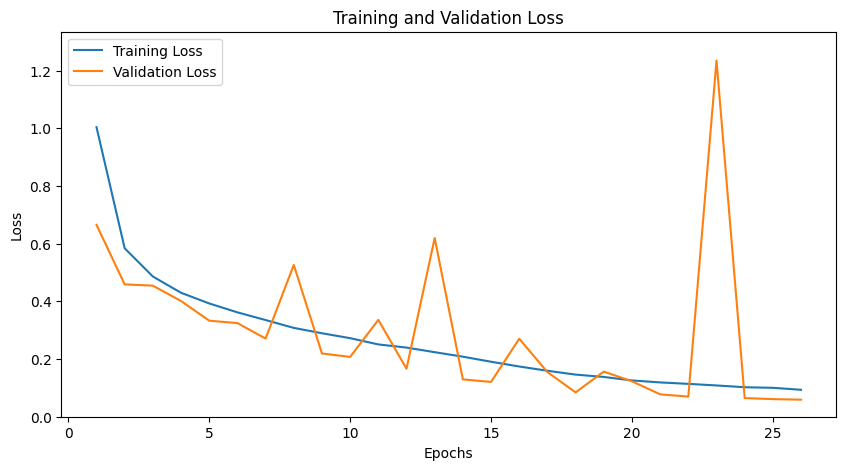

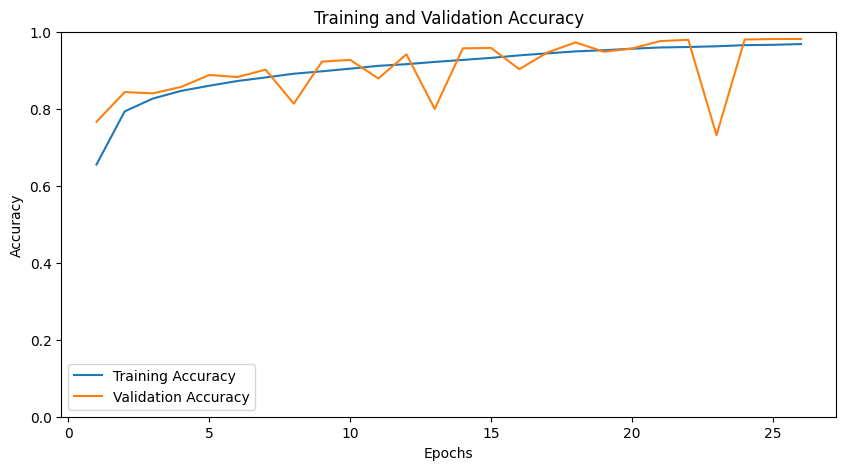

In [4]:

data = [
{"Epoch": [1/15], "Train Loss": 1.0037, "Train Accuracy": 0.6551, "Val Loss": 0.6651, "Val Accuracy": 0.7662},
{"Epoch": [2/15], "Train Loss": 0.5838, "Train Accuracy": 0.7931, "Val Loss": 0.4587, "Val Accuracy": 0.8432},
{"Epoch": [3/15], "Train Loss": 0.4860, "Train Accuracy": 0.8264, "Val Loss": 0.4543, "Val Accuracy": 0.8399},
{"Epoch": [4/15], "Train Loss": 0.4296, "Train Accuracy": 0.8463, "Val Loss": 0.4010, "Val Accuracy": 0.8566},
{"Epoch": [5/15], "Train Loss": 0.3926, "Train Accuracy": 0.8597, "Val Loss": 0.3329, "Val Accuracy": 0.8876},
{"Epoch": [6/15], "Train Loss": 0.3618, "Train Accuracy": 0.8720, "Val Loss": 0.3245, "Val Accuracy": 0.8823},
{"Epoch": [7/15], "Train Loss": 0.3351, "Train Accuracy": 0.8812, "Val Loss": 0.2709, "Val Accuracy": 0.9015},
{"Epoch": [8/15], "Train Loss": 0.3079, "Train Accuracy": 0.8909, "Val Loss": 0.5262, "Val Accuracy": 0.8131},
{"Epoch": [9/15], "Train Loss": 0.2893, "Train Accuracy": 0.8972, "Val Loss": 0.2192, "Val Accuracy": 0.9222},
{"Epoch": [10/15], "Train Loss": 0.2723, "Train Accuracy": 0.9040, "Val Loss": 0.2073, "Val Accuracy": 0.9269},
{"Epoch": [11/15], "Train Loss": 0.2506, "Train Accuracy": 0.9114, "Val Loss": 0.3356, "Val Accuracy": 0.8787},
{"Epoch": [12/15], "Train Loss": 0.2396, "Train Accuracy": 0.9157, "Val Loss": 0.1665, "Val Accuracy": 0.9412},
{"Epoch": [13/15], "Train Loss": 0.2237, "Train Accuracy": 0.9215, "Val Loss": 0.6194, "Val Accuracy": 0.7994},
{"Epoch": [14/15], "Train Loss": 0.2081, "Train Accuracy": 0.9268, "Val Loss": 0.1294, "Val Accuracy": 0.9568},
{"Epoch": [15/15], "Train Loss": 0.1906, "Train Accuracy": 0.9320, "Val Loss": 0.1206, "Val Accuracy": 0.9580},
{"Epoch": [15/25], "Train Loss": 0.1741, "Train Accuracy": 0.9386, "Val Loss": 0.2703, "Val Accuracy": 0.9027},
{"Epoch": [16/25], "Train Loss": 0.1593, "Train Accuracy": 0.9438, "Val Loss": 0.1547, "Val Accuracy": 0.9461},
{"Epoch": [17/25], "Train Loss": 0.1460, "Train Accuracy": 0.9489, "Val Loss": 0.0843, "Val Accuracy": 0.9722},
{"Epoch": [18/25], "Train Loss": 0.1379, "Train Accuracy": 0.9519, "Val Loss": 0.1564, "Val Accuracy": 0.9480},
{"Epoch": [19/25], "Train Loss": 0.1258, "Train Accuracy": 0.9559, "Val Loss": 0.1228, "Val Accuracy": 0.9563},
{"Epoch": [20/25], "Train Loss": 0.1189, "Train Accuracy": 0.9591, "Val Loss": 0.0776, "Val Accuracy": 0.9756},
{"Epoch": [21/25], "Train Loss": 0.1139, "Train Accuracy": 0.9603, "Val Loss": 0.0697, "Val Accuracy": 0.9791},
{"Epoch": [22/25], "Train Loss": 0.1084, "Train Accuracy": 0.9622, "Val Loss": 1.2345, "Val Accuracy": 0.7312},
{"Epoch": [23/25], "Train Loss": 0.1022, "Train Accuracy": 0.9651, "Val Loss": 0.0646, "Val Accuracy": 0.9798},
{"Epoch": [24/25], "Train Loss": 0.1002, "Train Accuracy": 0.9660, "Val Loss": 0.0610, "Val Accuracy": 0.9810},
{"Epoch": [25/25], "Train Loss": 0.0934, "Train Accuracy": 0.9680, "Val Loss": 0.0590, "Val Accuracy": 0.9811}
]

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for item in data:
    train_losses.append(item["Train Loss"])
    val_losses.append(item["Val Loss"])
    train_accuracies.append(item["Train Accuracy"])
    val_accuracies.append(item["Val Accuracy"])

epochs = list(range(1, 27))

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.1)
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()


As can be seen from our graphs, it seems as thought the last model did the best. Something interesting, the model did better a lot of the times on the validation set. This could be due to highly similar validation and training sets, and since the validation set is much smaller, then by chance it is doing better most of the time.

# Displaying incorrect results

To get a qualitative understanding of what the model gets wrong, we will evaluate it on a small subset of our valdiation set and display the incorrect outputs.

Validation Accuracy: 98.11%
Validation Loss: 0.0590


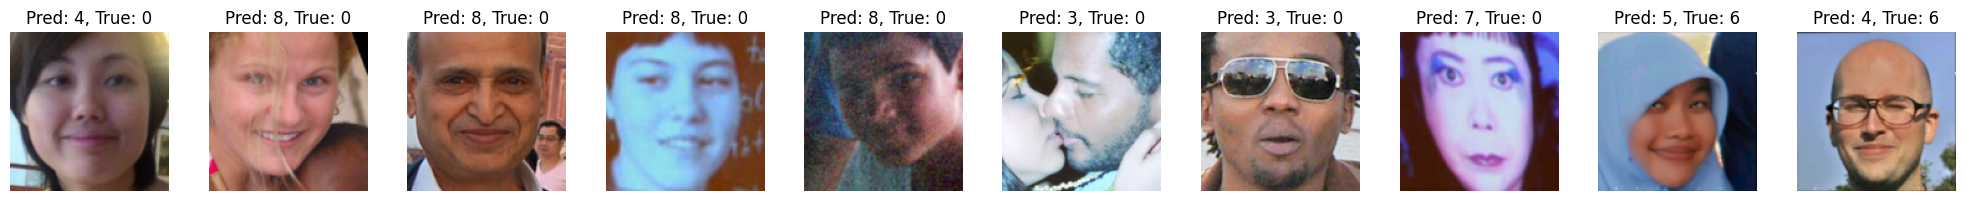

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os


checkpoint_path = os.path.join('checkpoints', 'checkpoint_epoch_25.pth')
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
subset_size = int(len(val_loader.dataset) * 0.1)
incorrect_images = []
incorrect_labels = []
predicted_labels = []
total_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)

        total_loss += loss.item() * images.size(0)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        wrong_indices = (predicted != labels)
        if wrong_indices.any():
            incorrect_images.extend(images[wrong_indices].cpu().numpy())
            incorrect_labels.extend(labels[wrong_indices].cpu().numpy())
            predicted_labels.extend(predicted[wrong_indices].cpu().numpy())

        if len(incorrect_images) >= subset_size:
            break

accuracy = (total_correct / total_samples) * 100
average_loss = total_loss / total_samples
print(f'Validation Accuracy: {accuracy:.2f}%')
print(f'Validation Loss: {average_loss:.4f}')
num_to_show = min(len(incorrect_images), 10)


num_rows = 1
num_cols = num_to_show
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
if num_to_show == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    img = np.transpose(incorrect_images[i], (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(f'Pred: {predicted_labels[i]}, True: {incorrect_labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [21]:
print(subset_size)

2076


# Interpretation of Results

It looks like most of the images it got wrong were unfiltered images that looked like they had filters, for example the 4th, 5th, and 8th image from the left look like they have filters.

Overall, it had a high accuracy, and is seemingly good at detecting *Instagram* filters. But since we want to be using this to detect all filters, the next model should include instagram filters and camera filters.

# Evaluate Model Per Class

In [ ]:



def evaluate_model_per_class(model, data_loader, device, class_labels):
    model.eval()

    correct_pred = {classname: 0 for classname in class_labels.values()}
    total_pred = {classname: 0 for classname in class_labels.values()}

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            for label, prediction in zip(labels, predictions):
                try:
                    classname = class_labels[label.item()]  # Convert label to item and get classname
                    if label == prediction:
                        correct_pred[classname] += 1
                    total_pred[classname] += 1
                except KeyError:
                    pass

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Class: {classname:15s} | Accuracy: {accuracy:.2f} % | Samples: {total_pred[classname]}')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model_per_class(model, val_loader, device, class_labels)
